Задача - создать модель, которая будет предсказывать стоимость автомобиля в Самарской области по его характеристикам. Данные для обучения были получены с объявлений сайта Авито с помощью парсинга (ноутбук `parsing.ipynb`)

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# считываем данные
data = pd.read_csv('../data/cars_data.csv', index_col=0)

data.sample(n=5)

,id,mark,name,price,params
19225,i4145555287,ВАЗ (LADA),"ВАЗ (LADA) Vesta 1.6 MT, 2021, 89 000 км",1195000,"89 000 км, 1.6 MT (106 л.с.), универсал, перед..."
1180,i4166597924,Changan,"Changan CS35 1.6 MT, 2013, 115 000 км",850000,"115 000 км, 1.6 MT (113 л.с.), внедорожник, пе..."
13325,i4008354404,Renault,"Renault Kangoo 1.5 MT, 2003, 179 000 км",430000,"179 000 км, 1.5 MT (65 л.с.), минивэн, передни..."
5814,i4170315676,Hyundai,"Hyundai ix35 2.0 MT, 2013, 164 346 км",1200000,"164 346 км, 2 MT (150 л.с.), внедорожник, пере..."
16349,i3785291551,Volkswagen,"Volkswagen Touareg 3.2 AT, 2005, 275 294 км",799000,"275 294 км, 3.2 AT (241 л.с.), внедорожник, по..."


In [3]:
# установим новый индекс
data.set_index('id', inplace=True)

In [4]:
# удалим дубликаты, посмотрим размерность
data.drop_duplicates(keep='first', inplace=True)
data.shape

(17818, 4)

In [5]:
# посмотрим на краткое описание данных
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17818 entries, i4126437279 to i4395822541
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   mark    17818 non-null  object
 1   name    17818 non-null  object
 2   price   17818 non-null  int64 
 3   params  17818 non-null  object
dtypes: int64(1), object(3)
memory usage: 696.0+ KB


### Обработка данных

In [6]:
# пропущенных значений нет
# начнем обработку признаков
data.sample(n=5)

,mark,name,price,params
id,,,,
i3528127177,Geely,"Geely Atlas 2.4 AT, 2018, 71 651 км",1889000,"71 651 км, 2.4 AT (149 л.с.), внедорожник, пол..."
i4121109429,Skoda,"Skoda Rapid 1.6 MT, 2017, 184 000 км",939000,"184 000 км, 1.6 MT (90 л.с.), лифтбек, передни..."
i4234371562,ВАЗ (LADA),"ВАЗ (LADA) 2114 Samara 1.6 MT, 2010, 193 000 км",165000,"193 000 км, 1.6 MT (81 л.с.), хетчбэк, передни..."
i4425709440,Hyundai,"Hyundai Santa Fe 2.7 AT, 2006, 261 000 км",1050000,"261 000 км, 2.7 AT (189 л.с.), внедорожник, по..."
i3927472922,Kia,"Kia Sportage 2.0 AT, 2017, 192 480 км",1810000,"192 480 км, 2.0 AT (150 л.с.), внедорожник, по..."


In [7]:
# В датасете есть новые автомобили (те, у которых пробег не указан), 
# их учитывать не нужно. Удалим такие записи 
data['name'] = data['name'].apply(lambda x: x if 'км' in x else None)
data.dropna(inplace=True)
data.shape

(17085, 4)

In [8]:
# из колонки name вытащим информацию,
# сколько лет автомобиль находится в эксплуатации
data['лет в эксплуатации'] = 2025 - data['name'].apply(lambda x: x.split(', ')[1]).apply(int)

In [9]:
# в датасете присутствуют битые авто
# cделаем отдельный признак
data['битый'] = data['name'].apply(lambda x: True if 'битый' in x else False)

In [10]:
# в признаке name оставим только название модели
data['модель'] = data['name'].apply(lambda x: ' '.join(x.split(', ')[0].split()[:-2]))
data.drop(columns='name', inplace=True)

In [11]:
# вытащим из params пробег
# сначала уберем пометку "Битый" у соответствующих машин
data['params'] = data['params'].apply(
    lambda x: x.replace("Битый, ", "") if "Битый" in x else x)

data['пробег'] = data['params'].apply(lambda x: x.split(', ')[0].replace('км', '').replace(' ', ''))

In [12]:
# проверим, что у всех авто в столбце params 5 блоков с информацией: 
# пробег, модификация, тип кузова, привод, тип топлива
data['params'].apply(lambda x: len(x.split(', '))).value_counts()

params
5    17054
4       31
Name: count, dtype: int64

In [13]:
# удалим некорректные записи
data['params'] = data['params'].apply(lambda x: x if len(x.split(', ')) == 5 else None)
data.dropna(inplace=True)

In [14]:
# создадим новые признаки - модификация, тип кузова, привод, тип топлива
data['модификация'] = data['params'].apply(lambda x: x.split(', ')[1])
data['тип кузова'] = data['params'].apply(lambda x: x.split(', ')[2])
data['привод'] = data['params'].apply(lambda x: x.split(', ')[3])
data['тип топлива'] = data['params'].apply(lambda x: x.split(', ')[4])

# удалим лишний теперь столбец params
data.drop(columns='params', inplace=True)

In [15]:
# из модификации достанем объем двигателя, тип трансмиссии и мощность

# Автомобили с электрическим типом двигателя не могут иметь такую характеристику, 
# так как у них в принципе отсутствует камера сгорания топлива, по которой считается объем. 
# Тогда можно сказать, что у электромобилей объем двигателя - 0 л и модель не будет учитывать данный признак
data.loc[data['тип топлива'] == 'электро', 'модификация'] = data[data['тип топлива'] == 'электро']['модификация'].apply(
    lambda x: '0 ' + x)

# создадим новые признаки
data['объём двигателя'] = data['модификация'].apply(lambda x: x.split()[0])
data['тип трансмиссии'] = data['модификация'].apply(lambda x: x.split()[1])
data['мощность'] = data['модификация'].apply(lambda x: x.split('(')[-1].split()[0])

# удалим ненужный
data.drop(columns='модификация', inplace=True)

In [16]:
# переименуем столбцы 
data.rename(columns={'mark': 'марка', 'price': 'цена'}, inplace=True)

In [17]:
# посмотрим на обработанный датасет
data.sample(n=5)

,марка,цена,лет в эксплуатации,битый,модель,пробег,тип кузова,привод,тип топлива,объём двигателя,тип трансмиссии,мощность
id,,,,,,,,,,,,
i4118564492,ГАЗ,270000,19,False,ГАЗ ГАЗель 3221,232740,микроавтобус,задний,бензин,2.5,MT,140
i4162325628,BMW,2450000,9,False,BMW 5 серия,148000,универсал,задний,дизель,2.0,AT,150
i3968465740,Kia,2750000,5,False,Kia K5,39000,седан,передний,бензин,1.6,AT,180
i4674186516,УАЗ,200000,31,False,УАЗ 3962,230000,микроавтобус,полный,бензин,2.5,MT,76
i4211343512,ВАЗ (LADA),285000,15,False,ВАЗ (LADA) Kalina,143758,седан,передний,бензин,1.6,MT,81


In [18]:
# посмотрим на типы колонок
data.dtypes

марка                 object
цена                   int64
лет в эксплуатации     int64
битый                   bool
модель                object
пробег                object
тип кузова            object
привод                object
тип топлива           object
объём двигателя       object
тип трансмиссии       object
мощность              object
dtype: object

In [19]:
# приведем колонки Пробег, Объём двигателя и Мощность к числовому типу
cols_to_num = ['пробег', 'объём двигателя', 'мощность']
data[cols_to_num] = data[cols_to_num].map(pd.to_numeric)

### EDA

In [20]:
# посмотрим на вещественные колонки
num_cols = ['цена', 'лет в эксплуатации', 'пробег', 'объём двигателя', 'мощность']

# изучим их
data[num_cols].describe()

,цена,лет в эксплуатации,пробег,объём двигателя,мощность
count,1.705400e+04,17054.000000,17054.000000,17054.000000,17054.000000
mean,1.607883e+06,11.475314,145239.819749,1.944594,139.076522
std,1.797618e+06,6.972494,92419.328182,0.634980,59.111816
min,2.255500e+04,1.000000,1.000000,0.000000,20.000000
25%,6.500000e+05,6.000000,80000.000000,1.600000,105.000000
50%,1.140000e+06,11.000000,137000.000000,1.600000,123.000000
75%,1.930000e+06,15.000000,196267.250000,2.000000,150.000000
max,3.450000e+07,103.000000,1000000.000000,6.200000,625.000000


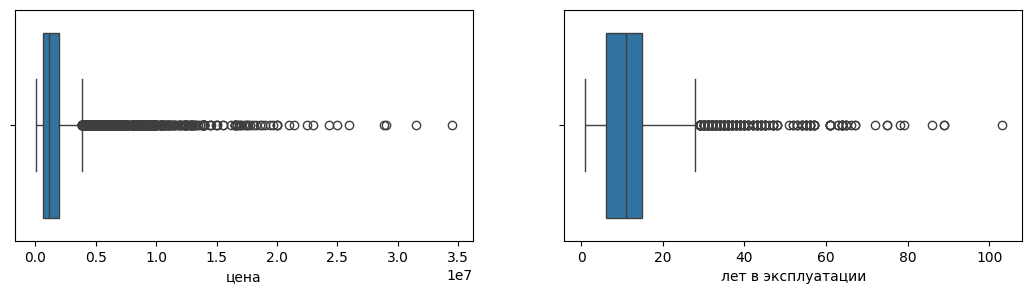

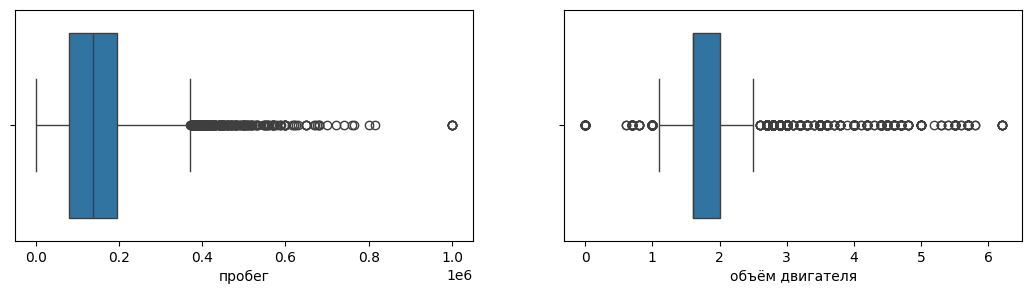

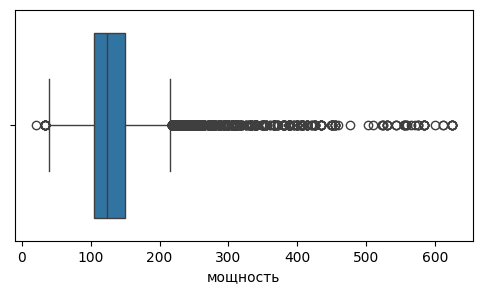

In [21]:
# нарисуем боксплоты для вещественных признаков
i=0
while i < 5:
    fig = plt.figure(figsize=[13,3])

    plt.subplot(1,2,1)
    sns.boxplot(x=num_cols[i], data=data)
    i += 1
    
    if i == 5: break
    plt.subplot(1,2,2)
    sns.boxplot(x=num_cols[i], data=data)
    i += 1
    
    plt.show()

In [22]:
# уберем самые сильные выбросы
data = data[(data['лет в эксплуатации'] <= 80) | (data['пробег'] <= 800000)]

In [23]:
# посмотрим на категориальные колонки
categorical_columns = data.loc[:,data.dtypes==object].columns

# изучим их
data.describe(include='object')

,марка,модель,тип кузова,привод,тип топлива,тип трансмиссии
count,17054,17054,17054,17054,17054,17054
unique,28,738,11,3,5,4
top,ВАЗ (LADA),ВАЗ (LADA) Granta,внедорожник,передний,бензин,MT
freq,2378,571,6232,10328,15039,8033


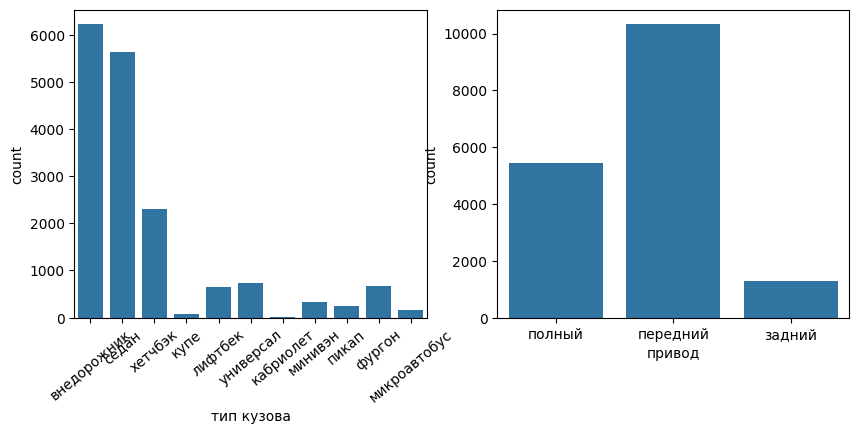

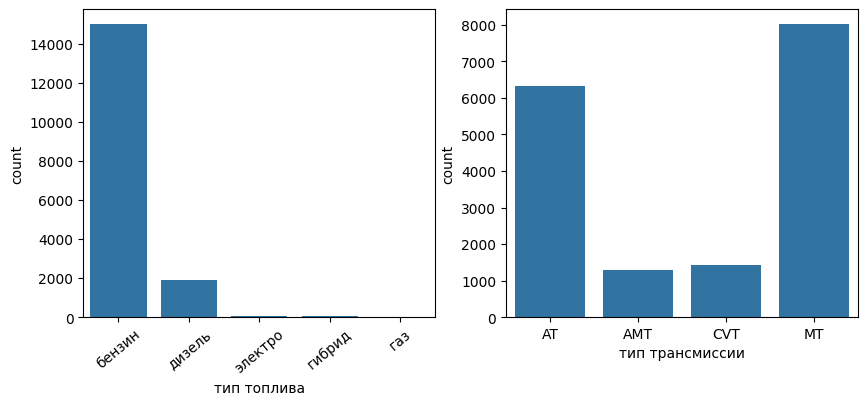

In [24]:
# посмотрим на распределение некоторых категориальных признаков
cat_cols = ['тип кузова','привод', 'тип топлива','тип трансмиссии']
i=0
while i < 4:
    fig = plt.figure(figsize=[10,4])
    
    plt.subplot(1,2,1)
    sns.countplot(x=cat_cols[i], data=data)
    i += 1
    
    plt.xticks(rotation=40)

    plt.subplot(1,2,2)
    sns.countplot(x=cat_cols[i], data=data)
    i += 1
    
    plt.show()

In [25]:
# закодируем категориальные колонки
for col in categorical_columns:
    if data[col].nunique() <= 5:
        one_hot = pd.get_dummies(data[col], prefix=col, drop_first=True)
        data = pd.concat((data.drop(col, axis=1), one_hot), axis=1)
    else:
        median_target = data.groupby(col)['цена'].median()
        data[col] = data[col].map(median_target)

In [26]:
# посмотримт на получившийся датасет
data.sample(n=5)

,марка,цена,лет в эксплуатации,битый,модель,пробег,тип кузова,объём двигателя,мощность,привод_передний,привод_полный,тип топлива_газ,тип топлива_гибрид,тип топлива_дизель,тип топлива_электро,тип трансмиссии_AT,тип трансмиссии_CVT,тип трансмиссии_MT
id,,,,,,,,,,,,,,,,,,
i4269878559,1280000.0,2590000,4,False,2299500.0,83000,1848000.0,1.4,150,True,False,False,False,False,False,False,False,False
i4530228437,1500000.0,1745000,5,False,1535000.0,110703,670000.0,1.6,123,True,False,False,False,False,False,True,False,False
i4152388793,1553500.0,200000,13,False,320000.0,133534,1179990.0,1.5,109,True,False,False,False,False,False,False,False,True
i4104623448,599000.0,680000,15,False,530000.0,55179,670000.0,1.0,68,True,False,False,False,False,False,False,False,False
i4345998369,719500.0,1185700,11,False,650000.0,113650,670000.0,1.4,140,True,False,False,False,False,False,True,False,False


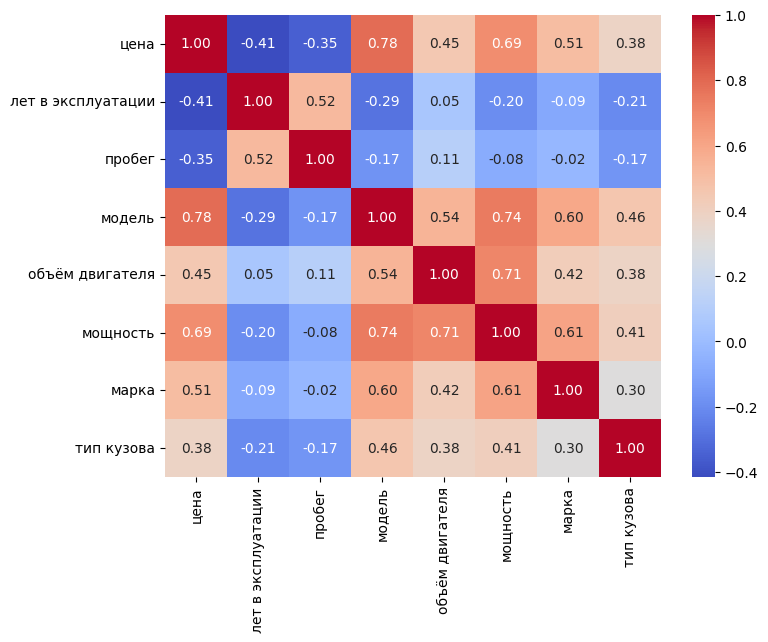

In [27]:
# посмотрим матрицу корреляций
corr_matrix = data[['цена', 'лет в эксплуатации', 'пробег', 'модель',
                    'объём двигателя', 'мощность', 'марка', 'тип кузова']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

### Обучение модели

In [28]:
# разделим и нормализуем выборку
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = data.drop(columns='цена')
y = data['цена']

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [29]:
# напишем функцию для вывода и сохранения метрик модели
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error 

MAE_train = []
MAE_test = []
R2_train = []
R2_test = []
MAPE_train = []
MAPE_test = []

def car_pred_model(model):
    model.fit(X_train, y_train)
            
    y_pred_train = model.predict(X_train)
    MAE_train_model = mean_absolute_error(y_train, y_pred_train)
    R2_train_model = r2_score(y_train, y_pred_train)
    MAPE_train_model = mean_absolute_percentage_error(y_train, y_pred_train)
    MAE_train.append(round(MAE_train_model, 3))
    R2_train.append(round(R2_train_model, 3))
    MAPE_train.append(round(MAPE_train_model, 3))
    
    y_pred_test = model.predict(X_test)
    MAE_test_model = mean_absolute_error(y_test, y_pred_test)
    R2_test_model = r2_score(y_test, y_pred_test)
    MAPE_test_model = mean_absolute_percentage_error(y_test, y_pred_test)
    MAE_test.append(round(MAE_test_model, 3))
    R2_test.append(round(R2_test_model, 3))
    MAPE_test.append(round(MAPE_test_model, 3))
    
    print("Train MAE:",round(MAE_train_model, 3))
    print("Test MAE:",round(MAE_test_model, 3))
    print("Train R2-score:",round(R2_train_model, 3))
    print("Test R2-score:",round(R2_test_model, 3))
    print("Train MAPE:",round(MAPE_train_model, 3))
    print("Test MAPE:",round(MAPE_test_model, 3))

In [30]:
# построим линейную регрессию
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()
car_pred_model(linear_regression)

Train MAE: 472692.946
Test MAE: 474651.709
Train R2-score: 0.722
Test R2-score: 0.713
Train MAPE: 0.525
Test MAPE: 0.512


In [31]:
# попробуем с L1 регуляризацией
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV

lasso = Lasso()

alpha = np.logspace(-4, 2, num=10)

lasso_rs = RandomizedSearchCV(lasso, param_distributions=dict(alpha=alpha))

car_pred_model(lasso_rs)

Train MAE: 471938.494
Test MAE: 473858.077
Train R2-score: 0.722
Test R2-score: 0.713
Train MAPE: 0.524
Test MAPE: 0.51


In [32]:
# попробуем с L2 регуляризацией
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV

ridge = Ridge()

alpha = np.logspace(-3, 1, num=10)

ridge_rs = RandomizedSearchCV(ridge, param_distributions = dict(alpha=alpha))

car_pred_model(ridge_rs)

Train MAE: 472628.769
Test MAE: 474582.685
Train R2-score: 0.722
Test R2-score: 0.713
Train MAPE: 0.525
Test MAPE: 0.512


In [37]:
# построим knn модель
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

param_grid = {
    'n_neighbors': [  1,  25,  50,  75, 100],
    'p': [1, 3, 5],
    'weights': ['uniform', 'distance']
}

knn_rs = RandomizedSearchCV(knn, param_distributions=param_grid)

car_pred_model(knn_rs)

Train MAE: 1851.833
Test MAE: 271263.948
Train R2-score: 1.0
Test R2-score: 0.855
Train MAPE: 0.001
Test MAPE: 0.222


In [38]:
# построим случайный лес
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor()

param_grid = {"n_estimators": [500, 600, 700, 800, 900],
              "max_depth": [2, 4, 8],
              "min_samples_split": [4, 6, 8],
              "min_samples_leaf": [1, 2, 5, 7]}

random_forest_rs = RandomizedSearchCV(
    random_forest, param_distributions=param_grid)

car_pred_model(random_forest_rs)

Train MAE: 231876.998
Test MAE: 268312.271
Train R2-score: 0.949
Test R2-score: 0.871
Train MAPE: 0.21
Test MAPE: 0.214


In [39]:
# построим градиентный бустинг
from catboost import CatBoostRegressor

cat_boost = CatBoostRegressor(silent=True)

param_grid = {
    'iterations': [200, 250, 300, 350, 400],
    'learning_rate': [0.1, 0.5, 1],
    'depth': [4, 6, 7, 8],
    'l2_leaf_reg': [0, 1e-4, 0.1, 1],
}

cat_boost_rs = RandomizedSearchCV(cat_boost, param_distributions=param_grid)

car_pred_model(cat_boost_rs)

Train MAE: 162017.59
Test MAE: 202963.794
Train R2-score: 0.98
Test R2-score: 0.913
Train MAPE: 0.155
Test MAPE: 0.169


In [42]:
# посмотрим на качество моделей
models = ["LinearRegression", "Ridge", "Lasso",
          "KNN", "RandomForestRegressor", "CatBoostRegressor"]
results = pd.DataFrame({'Model': models, 'MAE(Test)': MAE_test,
                        'R Squared(Test)': R2_test,
                        'MAPE(Test)': MAPE_test})
results

,Model,MAE(Test),R Squared(Test),MAPE(Test)
0,LinearRegression,474651.709,0.713,0.512
1,Ridge,473858.077,0.713,0.510
2,Lasso,474582.685,0.713,0.512
3,KNN,271263.948,0.855,0.222
4,RandomForestRegressor,268312.271,0.871,0.214
5,CatBoostRegressor,202963.794,0.913,0.169


In [51]:
# сохраним модель и scaler
import pickle

best_model = cat_boost_rs.best_estimator_

file_path_model = '../catboost_model.pkl'
file_path_scaler = '../scaler.pkl'
pickle.dump(best_model, open(file_path_model, 'wb'))
pickle.dump(scaler, open(file_path_scaler, 'wb'))

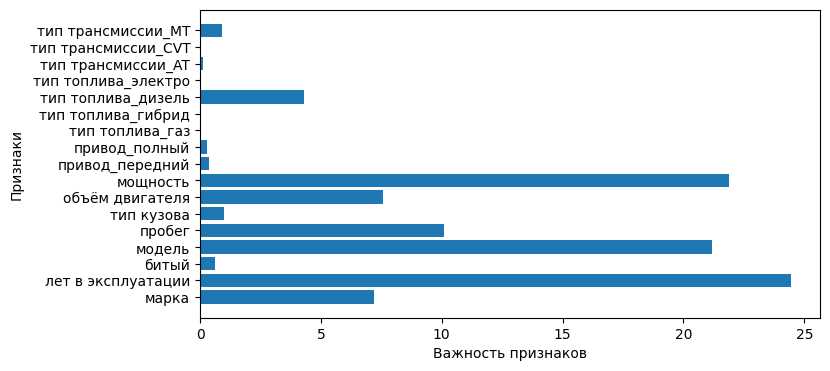

In [57]:
# посмотрим на важность признаков
feature_importance = best_model.get_feature_importance(type='FeatureImportance')
feature_names = data.drop(columns='цена').columns  

plt.figure(figsize=(8, 4))
plt.barh(range(len(feature_importance)), feature_importance, align='center')
plt.yticks(range(len(feature_importance)), feature_names)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.show()